In [9]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from math import e, pi
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit import transpile, assemble, Aer, IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.visualization.bloch import Bloch
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector, plot_histogram

ModuleNotFoundError: No module named 'qiskit'

In [2]:
def qft_rotations(circuit, n):
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1 # Indexes start from 0
    circuit.h(n) # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        # For each less significant qubit, we need to do a
        # smaller-angled controlled rotation: 
        circuit.cp(pi/2**(n-qubit), qubit, n)

In [3]:
from qiskit import QuantumCircuit, Aer, transpile, execute
from qiskit.circuit.library import QFT
import numpy as np

# 1. 입력 신호 준비: 상태 |ψ⟩ = 1/sqrt(2)(|0⟩ + |1⟩), |φ⟩ = 1/2(sqrt(3)|0⟩ + |1⟩)
psi = QuantumCircuit(1)
phi = QuantumCircuit(1)

# |ψ⟩ 상태
psi.initialize([1/np.sqrt(2), 1/np.sqrt(2)], 0)  # First qubit

# |φ⟩ 상태
phi.initialize([np.sqrt(3)/2, 1/2], 0)  # First qubit

state_psi = Statevector(phi)
state_phi = Statevector(psi)

psi_data = state_psi.data
phi_data = state_phi.data

print(psi_data, phi_data)
convolution_result = np.array([psi_data[0]*phi_data[0]+psi_data[1]*phi_data[1],psi_data[0]*phi_data[1]+psi_data[1]*phi_data[0]])

# 컨볼루션 결과를 새로운 Statevector로 변환
result_state = Statevector(convolution_result)

# 결과 출력
print("Convolution result as a quantum state:")
print(result_state)

[0.8660254+0.j 0.5      +0.j] [0.70710678+0.j 0.70710678+0.j]
Convolution result as a quantum state:
Statevector([0.96592583+0.j, 0.96592583+0.j],
            dims=(2,))


C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


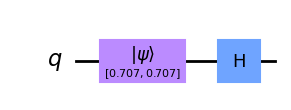

In [4]:
# 2. QFT 적용
qft_circuit = QFT(num_qubits=1).decompose()  # Create and decompose QFT for 2 qubits

psi_qft = psi.compose(qft_circuit)
psi_qft.draw('mpl')

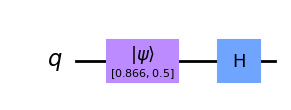

In [5]:
phi_qft = phi.compose(qft_circuit)
phi_qft.draw('mpl')

In [93]:
state_psi_qft = Statevector(psi_qft)
state_phi_qft = Statevector(phi_qft) 
print("|psi> = ", state_psi_qft)
print("|phi> = ", state_phi_qft)

element_wise = state_psi_qft.data * state_phi_qft.data
element_wise_result_state = Statevector(element_wise)

print("Element-wise product result = ", element_wise_result_state)
coeff = np.absolute(element_wise_result_state.data[0])
element_wise_result_state = element_wise_result_state / np.linalg.norm(element_wise_result_state.data)
element_wise_result = QuantumCircuit(1)
element_wise_result.initialize(element_wise_result_state)
elemen_wise_result_qft = element_wise_result.compose(qft_circuit)
elemen_wise_result_qft.draw('mpl')

|psi> =  Statevector([1.+0.j, 0.+0.j],
            dims=(2,))
|phi> =  Statevector([0.96592583+0.j, 0.25881905+0.j],
            dims=(2,))
Element-wise product result =  Statevector([0.96592583+0.j, 0.        +0.j],
            dims=(2,))


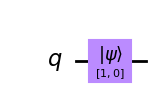

In [106]:
element_wise_result.draw('mpl')

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


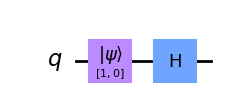

In [105]:
elemen_wise_result_qft.draw('mpl')

In [95]:
state_result_qft = Statevector(elemen_wise_result_qft)
state_result_qft = state_result_qft * np.sqrt(2) * coeff
state_result_qft

Statevector([0.96592583+0.j, 0.96592583+0.j],
            dims=(2,))


In [103]:
print( "Time domain convolution = ", result_state.data,"\n","Frequency domain multiplication = ",state_result_qft.data)

Time domain convolution =  [0.96592583+0.j 0.96592583+0.j] 
 Frequency domain multiplication =  [0.96592583+0.j 0.96592583+0.j]


# 3 qubits and 2 qubits Convolution

In [154]:
from qiskit import QuantumCircuit, Aer, transpile, execute
from qiskit.circuit.library import QFT
import numpy as np

In [209]:
# 1. 입력 신호 준비: 상태 |ψ⟩ = 1/sqrt(2)(|0⟩ + |1⟩), |φ⟩ = 1/2(sqrt(3)|0⟩ + |1⟩)
psi = QuantumCircuit(3)
phi = QuantumCircuit(2)

# |ψ⟩ 상태
psi.h(range(0,3))  # First qubit

In [210]:
# |φ⟩ 상태
initial_state = np.array([1,np.sqrt(2),np.sqrt(3),2]) * (1/np.sqrt(10))

# 2-큐빗 회로 생성
# 초기 상태 설정
phi.initialize(initial_state, [0, 1])

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


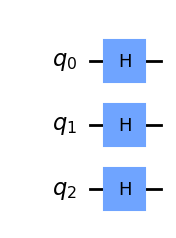

In [211]:
psi.draw('mpl')

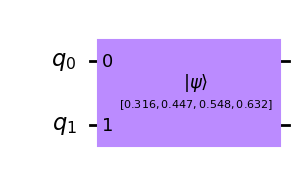

In [212]:
phi.draw('mpl')

In [160]:
state_psi = Statevector(phi)
state_phi = Statevector(psi)

psi_data = state_psi.data
phi_data = state_phi.data

print(psi_data, phi_data)
psi_real = psi_data.real
phi_real = phi_data.real

[0.31622777+0.j 0.4472136 +0.j 0.54772256+0.j 0.63245553+0.j] [0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]


In [162]:
# 순환 컨볼루션 함수 정의
def circular_convolution(x, y):
    L = len(y)  # y의 길이 (순환 주기)
    N = len(x)  # x의 길이
    z = np.zeros(N)  # 결과 배열 (x와 동일한 길이)
    
    for v in range(N):  # x의 각 요소에 대해
        for m in range(N):  # y를 순환적으로 접근
            z[v] += x[m] * y[(v - m) % L]  # 모듈로 연산으로 순환적 접근
    return z


In [163]:
# 순환 컨볼루션 계산
z = circular_convolution(psi_real, phi_real)

# 결과 출력
print("순환 컨볼루션 결과:")
print(z)


순환 컨볼루션 결과:
[0.68717325 0.68717325 0.68717325 0.68717325]


In [165]:
result_state = Statevector(z)

# 결과 출력
print("Convolution result as a quantum state:")
print(result_state)

Convolution result as a quantum state:
Statevector([0.68717325+0.j, 0.68717325+0.j, 0.68717325+0.j,
             0.68717325+0.j],
            dims=(2, 2))


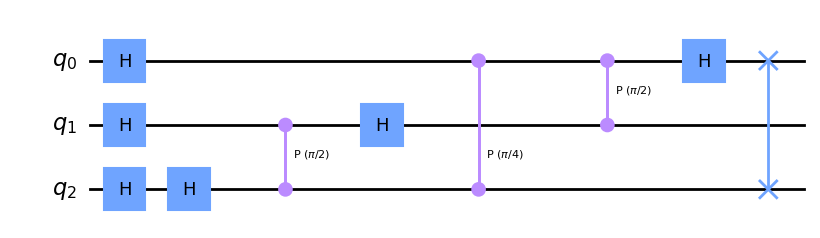

In [213]:
# 2. QFT 적용
qft_circuit = QFT(num_qubits=3).decompose()  # Create and decompose QFT for 2 qubits

psi_qft = psi.compose(qft_circuit)
psi_qft.draw('mpl')

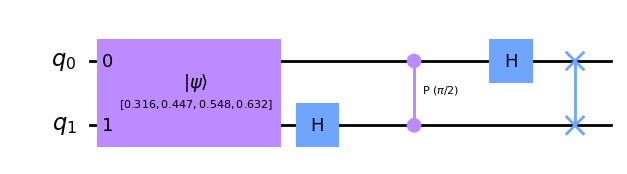

In [214]:
qft_circuit = QFT(num_qubits=2).decompose()
phi_qft = phi.compose(qft_circuit)
phi_qft.draw('mpl')

In [215]:
state_psi_qft = Statevector(psi_qft)
state_phi_qft = Statevector(phi_qft) 
print("|psi> = ", state_psi_qft)
print("|phi> = ", state_phi_qft)

|psi> =  Statevector([1.00000000e+00+0.00000000e+00j,
             1.55582133e-19+3.75608496e-19j,
             4.76210391e-18+4.76210391e-18j,
             1.55582133e-19+6.44442296e-20j,
             2.36158002e-17+0.00000000e+00j,
             1.55582133e-19-6.44442296e-20j,
             4.76210391e-18-4.76210391e-18j,
             1.55582133e-19-3.75608496e-19j],
            dims=(2, 2, 2))
|phi> =  Statevector([ 0.97180973+0.j        , -0.1157474 -0.09262097j,
             -0.1078594 +0.j        , -0.1157474 +0.09262097j],
            dims=(2, 2))


In [216]:
expanded_data = np.zeros(8, dtype=complex)  # 8개의 0 초기화
expanded_data[:4] = state_phi_qft.data  # 앞쪽 4개의 슬롯에 |phi> 값 복사

# 새로운 상태벡터 생성
phi_expanded = Statevector(expanded_data, dims=(2, 2, 2))

# 결과 출력
print("Expanded Statevector:")

print(phi_expanded)

Expanded Statevector:
Statevector([ 0.97180973+0.j        , -0.1157474 -0.09262097j,
             -0.1078594 +0.j        , -0.1157474 +0.09262097j,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ],
            dims=(2, 2, 2))


In [218]:
element_wise = state_psi_qft.data * phi_expanded.data
element_wise_result_state = Statevector(element_wise)

print("Element-wise product result = ", element_wise_result_state)
coeff = np.absolute(element_wise_result_state.data[0])
element_wise_result_state = element_wise_result_state / np.linalg.norm(element_wise_result_state.data)

Element-wise product result =  Statevector([ 9.71809726e-01+0.00000000e+00j,
              1.67809958e-20-5.78858730e-20j,
             -5.13637680e-19-5.13637680e-19j,
             -2.39771137e-20+6.95091606e-21j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j],
            dims=(2, 2, 2))


In [219]:
# Statevector 객체 생성
element_wise_result_state = Statevector(element_wise_result_state, dims=(2, 2, 2))

# 앞 4개의 요소만 선택
trimmed_data = element_wise_result_state.data[:4]

# 새로운 2-qubit Statevector 생성
trimmed_state = Statevector(trimmed_data, dims=(2, 2))

# 결과 출력
print("Trimmed Statevector:")
print(trimmed_state)

Trimmed Statevector:
Statevector([ 1.00000000e+00+0.00000000e+00j,
              1.72677793e-20-5.95650275e-20j,
             -5.28537292e-19-5.28537292e-19j,
             -2.46726422e-20+7.15254837e-21j],
            dims=(2, 2))


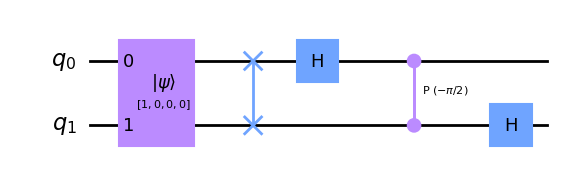

In [220]:
element_wise_result = QuantumCircuit(2)
element_wise_result.initialize(trimmed_state, [0,1,])
qft_circuit = QFT(num_qubits=2, inverse=True).decompose()
elemen_wise_result_qft = element_wise_result.compose(qft_circuit)
elemen_wise_result_qft.draw('mpl')

In [221]:
state_result_qft = Statevector(elemen_wise_result_qft)
state_result_qft = state_result_qft  * np.sqrt(2) * coeff
state_result_qft

Statevector([0.68717325-3.99213140e-19j, 0.68717325+3.34376351e-19j,
             0.68717325-3.27180233e-19j, 0.68717325+3.92017022e-19j],
            dims=(2, 2))


In [222]:
print( "Time domain convolution = ", result_state.data,"\n","Frequency domain multiplication = ",state_result_qft.data)

Time domain convolution =  [0.68717325+0.j 0.68717325+0.j 0.68717325+0.j 0.68717325+0.j] 
 Frequency domain multiplication =  [0.68717325-3.99213140e-19j 0.68717325+3.34376351e-19j
 0.68717325-3.27180233e-19j 0.68717325+3.92017022e-19j]


## Time Measurement

In [188]:
import time
import timeit
import cProfile

### Classical

In [4]:
def circular_convolution(x, y):
    L = len(y)  # y의 길이 (순환 주기)
    N = len(x)  # x의 길이
    z = np.zeros(N)  # 결과 배열 (x와 동일한 길이)
    
    for v in range(N):  # x의 각 요소에 대해
        for m in range(N):  # y를 순환적으로 접근
            z[v] += x[m] * y[(v - m) % L]  # 모듈로 연산으로 순환적 접근
    return z

In [183]:
# 순환 컨볼루션 계산
start = time.time()
psi_classic = np.array([1,1,1,1,1,1,1,1]) * (1/np.sqrt(8))
phi_classic = np.array([1,np.sqrt(2),np.sqrt(3),np.sqrt(4)]) * (1/np.sqrt(10))

z = circular_convolution(phi_classic,psi_classic)
end = time.time()

# 결과 출력
print("순환 컨볼루션 결과:")
print(z)
print(f"{end - start:.5f} sec")


순환 컨볼루션 결과:
[0.68717325 0.68717325 0.68717325 0.68717325]
0.00000 sec


In [185]:
code_to_test = """
psi_classic = np.array([1,1,1,1,1,1,1,1]) * (1/np.sqrt(8))
phi_classic = np.array([1,np.sqrt(2),np.sqrt(3),np.sqrt(4)]) * (1/np.sqrt(10))

z = circular_convolution(phi_classic,psi_classic)
"""

execution_time = timeit.timeit(code_to_test, globals=globals(), number=10000)
print(f"Execution time for 10,000 runs: {execution_time:.5f} seconds")

Execution time for 10,000 runs: 0.21080 seconds


In [ ]:
def calculate():
    psi_classic = np.array([1,1,1,1,1,1,1,1]) * (1/np.sqrt(8))
    phi_classic = np.array([1,np.sqrt(2),np.sqrt(3),np.sqrt(4)]) * (1/np.sqrt(10))

    z = circular_convolution(phi_classic,psi_classic)
    print(z)

cProfile.run("calculate()")

[0.68717325 0.68717325 0.68717325 0.68717325]
         185 function calls (181 primitive calls) in 0.001 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 1372850889.py:1(circular_convolution)
        1    0.000    0.000    0.001    0.001 323326338.py:3(calculate)
        1    0.000    0.000    0.001    0.001 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 _ufunc_config.py:132(geterr)
        2    0.000    0.000    0.000    0.000 _ufunc_config.py:33(seterr)
        1    0.000    0.000    0.000    0.000 _ufunc_config.py:426(__init__)
        1    0.000    0.000    0.000    0.000 _ufunc_config.py:430(__enter__)
        1    0.000    0.000    0.000    0.000 _ufunc_config.py:435(__exit__)
        4    0.000    0.000    0.000    0.000 arrayprint.py:1018(__call__)
        1    0.000    0.000    0.000    0.000 arrayprint.py:1595(_array_str_implementation)
        1    

### Quantum circuit

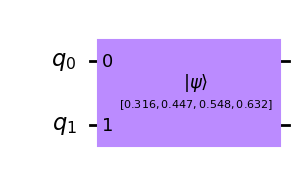

In [204]:
phi = QuantumCircuit(2)
initial_state = np.array([1,np.sqrt(2),np.sqrt(3),2]) * (1/np.sqrt(10))  # |00>, |01>, |10>, |11>에 대한 계수

# 2-큐빗 회로 생성
# 초기 상태 설정
phi.initialize(initial_state, [0, 1])
phi.draw('mpl')

In [ ]:
start = time.time()
# 1. 입력 신호 준비: 상태 |ψ⟩ = 1/sqrt(2)(|0⟩ + |1⟩), |φ⟩ = 1/2(sqrt(3)|0⟩ + |1⟩)
psi = QuantumCircuit(3)
phi = QuantumCircuit(2)

# |ψ⟩ 상태
psi.h(range(0,3))  # First qubit

# |φ⟩ 상태
initial_state = np.array([1,np.sqrt(2),np.sqrt(3),2]) * (1/np.sqrt(10))

# 2-큐빗 회로 생성
# 초기 상태 설정
phi.initialize(initial_state, [0, 1])

# 2. QFT 적용
qft_circuit = QFT(num_qubits=3).decompose()  # Create and decompose QFT for 2 qubits
psi_qft = psi.compose(qft_circuit)

qft_circuit = QFT(num_qubits=2).decompose()
phi_qft = phi.compose(qft_circuit)

state_psi_qft = Statevector(psi_qft)
state_phi_qft = Statevector(phi_qft) 

expanded_data = np.zeros(8, dtype=complex)  # 8개의 0 초기화
expanded_data[:4] = state_phi_qft.data  # 앞쪽 4개의 슬롯에 |phi> 값 복사

# 새로운 상태벡터 생성
phi_expanded = Statevector(expanded_data, dims=(2, 2, 2))

element_wise = state_psi_qft.data * phi_expanded.data
element_wise_result_state = Statevector(element_wise)

#print("Element-wise product result = ", element_wise_result_state)
coeff = np.absolute(element_wise_result_state.data[0])
element_wise_result_state = element_wise_result_state / np.linalg.norm(element_wise_result_state.data)

# Statevector 객체 생성
element_wise_result_state = Statevector(element_wise_result_state, dims=(2, 2, 2))

# 앞 4개의 요소만 선택
trimmed_data = element_wise_result_state.data[:4]

# 새로운 2-qubit Statevector 생성
trimmed_state = Statevector(trimmed_data, dims=(2, 2))

element_wise_result = QuantumCircuit(2)
element_wise_result.initialize(trimmed_state, [0,1,])
elemen_wise_result_qft = element_wise_result.compose(qft_circuit)

state_result_qft = Statevector(elemen_wise_result_qft)
state_result_qft = state_result_qft  * np.sqrt(2) * coeff

end = time.time()
print("Frequency domain multiplication = ",state_result_qft.data)
print(f"{end - start:.5f} sec")

Frequency domain multiplication =  [0.68717325-3.99213140e-19j 0.68717325+3.92017022e-19j
 0.68717325-3.27180233e-19j 0.68717325+3.34376351e-19j]
0.00898 sec


In [206]:
code_to_test = """
psi = QuantumCircuit(3)
phi = QuantumCircuit(2)

# |ψ⟩ 상태
psi.h(range(0,3))  # First qubit

# |φ⟩ 상태
initial_state = np.array([1,np.sqrt(2),np.sqrt(3),2]) * (1/np.sqrt(10))

# 2-큐빗 회로 생성
# 초기 상태 설정
phi.initialize(initial_state, [0, 1])

# 2. QFT 적용
qft_circuit = QFT(num_qubits=3).decompose()  # Create and decompose QFT for 2 qubits
psi_qft = psi.compose(qft_circuit)

qft_circuit = QFT(num_qubits=2).decompose()
phi_qft = phi.compose(qft_circuit)

state_psi_qft = Statevector(psi_qft)
state_phi_qft = Statevector(phi_qft) 

expanded_data = np.zeros(8, dtype=complex)  # 8개의 0 초기화
expanded_data[:4] = state_phi_qft.data  # 앞쪽 4개의 슬롯에 |phi> 값 복사

# 새로운 상태벡터 생성
phi_expanded = Statevector(expanded_data, dims=(2, 2, 2))

element_wise = state_psi_qft.data * phi_expanded.data
element_wise_result_state = Statevector(element_wise)

#print("Element-wise product result = ", element_wise_result_state)
coeff = np.absolute(element_wise_result_state.data[0])
element_wise_result_state = element_wise_result_state / np.linalg.norm(element_wise_result_state.data)

# Statevector 객체 생성
element_wise_result_state = Statevector(element_wise_result_state, dims=(2, 2, 2))

# 앞 4개의 요소만 선택
trimmed_data = element_wise_result_state.data[:4]

# 새로운 2-qubit Statevector 생성
trimmed_state = Statevector(trimmed_data, dims=(2, 2))

element_wise_result = QuantumCircuit(2)
element_wise_result.initialize(trimmed_state, [0,1,])
elemen_wise_result_qft = element_wise_result.compose(qft_circuit)

state_result_qft = Statevector(elemen_wise_result_qft)
state_result_qft = state_result_qft  * np.sqrt(2) * coeff
"""

execution_time = timeit.timeit(code_to_test, globals=globals(), number=10000)
print(f"Execution time for 10,000 runs: {execution_time:.5f} seconds")

Execution time for 10,000 runs: 44.98073 seconds


In [208]:
def calculate():
    psi = QuantumCircuit(3)
    phi = QuantumCircuit(2)

    # |ψ⟩ 상태
    psi.h(range(0,3))  # First qubit

    # |φ⟩ 상태
    initial_state = np.array([1,np.sqrt(2),np.sqrt(3),2]) * (1/np.sqrt(10))

    # 2-큐빗 회로 생성
    # 초기 상태 설정
    phi.initialize(initial_state, [0, 1])

    # 2. QFT 적용
    qft_circuit = QFT(num_qubits=3).decompose()  # Create and decompose QFT for 2 qubits
    psi_qft = psi.compose(qft_circuit)

    qft_circuit = QFT(num_qubits=2).decompose()
    phi_qft = phi.compose(qft_circuit)

    state_psi_qft = Statevector(psi_qft)
    state_phi_qft = Statevector(phi_qft) 

    expanded_data = np.zeros(8, dtype=complex)  # 8개의 0 초기화
    expanded_data[:4] = state_phi_qft.data  # 앞쪽 4개의 슬롯에 |phi> 값 복사

    # 새로운 상태벡터 생성
    phi_expanded = Statevector(expanded_data, dims=(2, 2, 2))

    element_wise = state_psi_qft.data * phi_expanded.data
    element_wise_result_state = Statevector(element_wise)

    #print("Element-wise product result = ", element_wise_result_state)
    coeff = np.absolute(element_wise_result_state.data[0])
    element_wise_result_state = element_wise_result_state / np.linalg.norm(element_wise_result_state.data)

    # Statevector 객체 생성
    element_wise_result_state = Statevector(element_wise_result_state, dims=(2, 2, 2))

    # 앞 4개의 요소만 선택
    trimmed_data = element_wise_result_state.data[:4]

    # 새로운 2-qubit Statevector 생성
    trimmed_state = Statevector(trimmed_data, dims=(2, 2))

    element_wise_result = QuantumCircuit(2)
    element_wise_result.initialize(trimmed_state, [0,1,])
    elemen_wise_result_qft = element_wise_result.compose(qft_circuit)

    state_result_qft = Statevector(elemen_wise_result_qft)
    state_result_qft = state_result_qft  * np.sqrt(2) * coeff

    print("Frequency domain multiplication = ",state_result_qft.data)

cProfile.run("calculate()")

Frequency domain multiplication =  [0.68717325-3.99213140e-19j 0.68717325+3.92017022e-19j
 0.68717325-3.27180233e-19j 0.68717325+3.34376351e-19j]
         14018 function calls (13530 primitive calls) in 0.018 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.018    0.018 3831187040.py:1(calculate)
       10    0.000    0.000    0.000    0.000 <frozen _collections_abc>:812(__init__)
      266    0.000    0.000    0.000    0.000 <frozen abc>:117(__instancecheck__)
       44    0.000    0.000    0.000    0.000 <frozen abc>:121(__subclasscheck__)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1101(_sanity_check)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1165(_find_and_load)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1192(_gcd_import)
       25    0.000    0.000    0.000    0.000 <frozen importlib._boots

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT
import numpy as np

# 초기 상태 |psi>와 |phi>
psi = [1/np.sqrt(2), 1/np.sqrt(2)]  # |psi> = 1/sqrt(2) * (|0> + |1>)
phi = [1/2, np.sqrt(3)/2,1/2]           # |phi> = 1/2 * |0> + sqrt(3)/2 * |1>

# Qiskit Statevector로 변환
state_psi = Statevector(psi)
state_phi = Statevector(phi)

# 두 상태를 병합 (텐서곱)
combined_state = state_psi.tensor(state_phi)

# QFT 적용을 위한 회로 생성
num_qubits = int(np.log2(len(combined_state.data)))  # 병합된 상태의 전체 퀴빗 수
qft_circuit = QFT(num_qubits, do_swaps=False)        # QFT 회로 생성

# QFT 적용
qft_result = combined_state.evolve(qft_circuit)

# QFT 결과에서 element-wise multiplication 수행
elementwise_product = qft_result.data * qft_result.data  # 두 상태를 성분별 곱셈

# 결과를 새로운 Statevector로 변환
result_state = Statevector(elementwise_product)

# 결과 출력
print("Element-wise multiplication after QFT:")
print("Statevector:", result_state)


Element-wise multiplication after QFT:
Statevector: Statevector([ 9.33012702e-01+0.00000000e+00j,
              6.69872981e-02+0.00000000e+00j,
             -5.50479898e-35+4.33518933e-35j,
             -5.50479898e-35-4.33518933e-35j],
            dims=(2, 2))


In [ ]:
# 순환 컨볼루션 계산
z = circular_convolution(psi_real, phi_real)

# 결과 출력
print("순환 컨볼루션 결과:")
print(z)


In [7]:
image = np.array([0,1,0,0,1,0])
filter = np.array([0,1,0,1])
circular_convolution(image,filter)

array([1., 1., 1., 1., 1., 1.])

In [16]:
circular_convolution(filter,image)

array([0., 1., 1., 0.])

In [15]:
np.convolve(image,filter)

array([0, 0, 1, 0, 1, 1, 0, 1, 0])

In [13]:
image.reshape(-1,3)
filter.reshape(-1,2)

array([[0, 1],
       [0, 1]])

In [9]:
import scipy
from scipy import signal
from scipy.signal import convolve2d

convolve2d(image,filter)

ValueError: convolve2d inputs must both be 2-D arrays

In [2]:
import numpy as np

# Input image and filter
I = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
F = np.array([[1, 0],
              [0, 1]])

# Flatten input and filter
I_flat = I.flatten()
F_flat = F.flatten()

# Compute 1D convolution
window_size = F_flat.size
output_1d = np.array([
    np.sum(I_flat[i:i+window_size] * F_flat)
    for i in range(len(I_flat) - window_size + 1)
])

# Correctly reshape 1D output to match the 2D output shape
output_2d_shape = (I.shape[0] - F.shape[0] + 1, I.shape[1] - F.shape[1] + 1)  # (2, 2)
output_2d = output_1d[:np.prod(output_2d_shape)].reshape(output_2d_shape)

print("1D Output:", output_1d)
print("2D Output:\n", output_2d)


1D Output: [ 5  7  9 11 13 15]
2D Output:
 [[ 5  7]
 [ 9 11]]


In [7]:
I.shape

(3, 3)

In [5]:
I_flat

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
for i in range(len(I_flat) - window_size + 1):
    print(i)

0
1
2
3
4
5


In [4]:
window_size

4

In [3]:
output_1d

array([ 5,  7,  9, 11, 13, 15])

In [56]:
import numpy as np

def sliding_window_1d(image, filter_size):
    """Generates a sliding window matrix for the given image and filter size."""
    n = image.shape[0]
    k = filter_size
    output_size = (n - k + 1) ** 2
    patch_size = k * k

    # Generate sliding window patches
    patches = []
    for i in range(n - k + 1):
        for j in range(n - k + 1):
            patch = image[i:i+k, j:j+k].flatten()
            patches.append(patch)
    return np.array(patches)

def flatten_1d_convolution(image, kernel):
    """Computes 1D convolution equivalent to 2D convolution."""
    # Extract sliding window patches
    patches = sliding_window_1d(image, kernel.shape[0])
    kernel_flat = kernel.flatten()

    # Compute dot product for 1D convolution
    result = patches @ kernel_flat
    output_size = (image.shape[0] - kernel.shape[0] + 1, 
                   image.shape[1] - kernel.shape[1] + 1)
    return result.reshape(output_size)

# Input 2D image and kernel
image = np.array([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]])
kernel = np.array([[1, 0],
                   [0, 1]])

# Perform 1D convolution
output = flatten_1d_convolution(image, kernel)
print("2D Convolution result using 1D approach:\n", output)


2D Convolution result using 1D approach:
 [[ 6  8]
 [12 14]]


In [57]:
filter_flat = filter.flatten()
filter_flat
for i, coeff in enumerate(filter_flat):

    print(int(np.floor(np.sqrt(i))))

0
1
1
1


In [58]:
image.size

9

In [59]:
from qiskit import QuantumCircuit, Aer, execute
import numpy as np

def encode_image(qc, image):
    """Encodes the image into quantum amplitudes."""
    n = image.size
    norm = np.linalg.norm(image)
    normalized = image.flatten() / norm
    qc.initialize(normalized, range(int(np.log2(n))))

def apply_filter(qc, filter, image_size):
    """Applies a quantum filter operation by mapping filter values to states."""
    # Flatten and normalize filter (optional, if normalization is required)
    filter_flat = filter.flatten()
    
    # Apply RY rotations corresponding to the filter coefficients
    n_states = image_size**2  # Number of states
    for i, coeff in enumerate(filter_flat):
        if coeff != 0:
            angle = 2 * np.arcsin(coeff)  # Map filter value to rotation angle
            qc.ry(angle, int(np.floor(np.sqrt(i)))) # Apply rotation to the corresponding state

# Define 2x2 image and 2x2 filter
image = np.array([[1, 2],
                  [3, 4]])
filter = np.array([[1, 0],
                   [0, -1]])

# Quantum circuit setup  
n_qubits = int(np.log2(image.size))  # 2 qubits for 2x2 image
qc = QuantumCircuit(n_qubits)

# Encode image and apply filter
encode_image(qc, image)
apply_filter(qc, filter, image.size)

# Display circuit
print("Quantum Circuit:")
print(qc)


Quantum Circuit:
     ┌─────────────────────────────────────────────┐┌───────┐ 
q_0: ┤0                                            ├┤ Ry(π) ├─
     │  Initialize(0.18257,0.36515,0.54772,0.7303) │├───────┴┐
q_1: ┤1                                            ├┤ Ry(-π) ├
     └─────────────────────────────────────────────┘└────────┘


C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


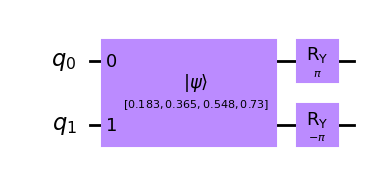

In [60]:
qc.draw('mpl')

In [55]:
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.quantum_info import Statevector

# Define 2D input and filter
image = np.array([[1, 2], [3, 4]])
filter_ = np.array([[1, 0], [0, -1]])

# Flatten the 2D arrays to 1D
image_flattened = image.flatten()
filter_flattened = filter_.flatten()

# Normalize for amplitude encoding
image_norm = image_flattened / np.linalg.norm(image_flattened)
filter_norm = filter_flattened / np.linalg.norm(filter_flattened)

# Create Quantum Circuit
n_qubits = int(np.ceil(np.log2(len(image_flattened))))
qc = QuantumCircuit(n_qubits)

# Amplitude encoding
def amplitude_encoding(qc, data):
    for i, amp in enumerate(data):
        if amp != 0:
            angle = 2 * np.arcsin(np.sqrt(abs(amp)))
            qc.ry(angle, i)

# Apply QFT
def qft(qc, n):
    for i in range(n):
        qc.h(i)
        for j in range(i + 1, n):
            qc.cp(np.pi / 2 ** (j - i), j, i)

# Apply IQFT
def iqft(qc, n):
    for i in range(n - 1, -1, -1):
        for j in range(i + 1, n):
            qc.cp(-np.pi / 2 ** (j - i), j, i)
        qc.h(i)

# Initialize and encode data
amplitude_encoding(qc, image_norm)
qft(qc, n_qubits)

# Apply filter in Fourier space
for i, coeff in enumerate(filter_norm):
    if coeff != 0:
        qc.ry(2 * np.arcsin(coeff), i)

# Inverse QFT
iqft(qc, n_qubits)

# Simulate and measure
simulator = Aer.get_backend('statevector_simulator')
result = execute(qc, simulator).result()
state = Statevector(result.get_statevector(qc))

print("Resulting statevector (amplitude encoded convolution result):")
print(state)


CircuitError: 'Index 2 out of range for size 2.'

In [61]:
import numpy as np

# Original data
I = np.array([1, 2, 3, 4])
K = np.array([1, 0, 0, -1])

# Create masks for non-negative indices
mask = np.array([1 if n >= 0 else 0 for n in range(len(I))])

# Apply the mask to ignore negative indices
I_masked = I * mask
K_masked = K * mask

# Compute FT and IFT
FT_I = np.fft.fft(I_masked)
FT_K = np.fft.fft(K_masked)

# Convolution using FT
result = np.fft.ifft(FT_I * FT_K)

print("Convolution result:", result.real)


Convolution result: [-1. -1. -1.  3.]


# 2D image Convolution 비교

In [66]:
import numpy as np

# Define a 2x2 input matrix
image = np.array([[1, 2],
                  [3, 4]])
filter=  np.array([[1,0],
                   [0,-1]])
# 2D Fourier Transform using numpy
ft_2d = np.fft.fft2(image)
ft_filter = np.fft.fft2(filter)

# Print the result
print("Original Image:")
print(image)

print("\n2D Fourier Transform:")
print(ft_2d)


print("Original Image:")
print(filter)

print("\n2D Fourier Transform:")
print(ft_filter)

Original Image:
[[1 2]
 [3 4]]

2D Fourier Transform:
[[10.+0.j -2.+0.j]
 [-4.+0.j  0.+0.j]]
Original Image:
[[ 1  0]
 [ 0 -1]]

2D Fourier Transform:
[[0.+0.j 2.+0.j]
 [2.+0.j 0.+0.j]]


In [68]:
# Element-wise multiplication in the Fourier domain
ft_result = ft_2d * ft_filter

# Inverse Fourier Transform to get the result back to spatial domain
result = np.fft.ifft2(ft_result)
result

array([[-3.+0.j, -1.+0.j],
       [ 1.+0.j,  3.+0.j]])

In [71]:
import numpy as np

def circular_convolution_2d(image, kernel):
    """
    2D 순환 컨볼루션을 수행하는 함수
    :param image: 2D 입력 이미지 (numpy array)
    :param kernel: 2D 커널 (numpy array)
    :return: 2D 순환 컨볼루션 결과 (numpy array)
    """
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape

    # 결과 배열 초기화
    result = np.zeros_like(image, dtype=float)

    # 순환적 컨볼루션 수행
    for i in range(image_h):
        for j in range(image_w):
            for m in range(kernel_h):
                for n in range(kernel_w):
                    # 순환적으로 인덱스 접근
                    image_row = (i - m) % image_h
                    image_col = (j - n) % image_w
                    result[i, j] += image[image_row, image_col] * kernel[m, n]
    
    return result


In [72]:
circular_convolution_2d(image, filter)

array([[-3., -1.],
       [ 1.,  3.]])

## 2D image convolution with quantum circuit

In [147]:
# 1. 입력 신호 준비: 상태 |ψ⟩ = 1/sqrt(2)(|0⟩ + |1⟩), |φ⟩ = 1/2(sqrt(3)|0⟩ + |1⟩)
psi = QuantumCircuit(2)
phi = QuantumCircuit(2)

# |ψ⟩ 상태
initial_psi_state = np.array([1,2,3,4]) * (1/np.sqrt(30))

# |φ⟩ 상태
initial_phi_state = np.array([1,0,0,-1]) * (1/np.sqrt(2))

psi.initialize(initial_psi_state,[0,1])
phi.initialize(initial_phi_state, [0, 1])

In [148]:
state_psi = Statevector(phi)
state_phi = Statevector(psi)

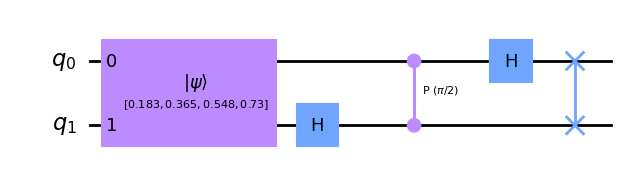

In [149]:
# 2. QFT 적용
qft_circuit = QFT(num_qubits=2).decompose()  # Create and decompose QFT for 2 qubits

psi_qft = psi.compose(qft_circuit)
phi_qft = phi.compose(qft_circuit)
psi_qft.draw('mpl')

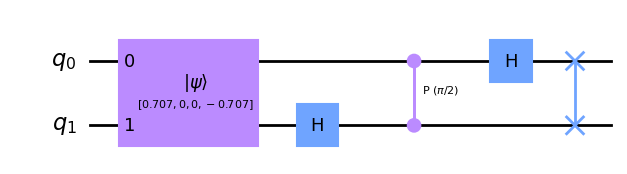

In [150]:
phi_qft.draw('mpl')

In [151]:
state_psi_qft = Statevector(psi_qft)
state_phi_qft = Statevector(phi_qft)
print(state_psi_qft)
print(state_phi_qft)

Statevector([ 0.91287093+0.j        , -0.18257419-0.18257419j,
             -0.18257419+0.j        , -0.18257419+0.18257419j],
            dims=(2, 2))
Statevector([2.29934717e-17+0.j        , 3.53553391e-01+0.35355339j,
             7.07106781e-01+0.j        , 3.53553391e-01-0.35355339j],
            dims=(2, 2))


In [152]:
element_wise = state_psi_qft.data * state_phi_qft.data
element_wise_state = Statevector(element_wise)
print("Element-wise multiplication result = ","\n",element_wise_state)
# element-wise 곱셈 결과 크기가 1이 아니므로 정규화
element_wise_state_norm = element_wise_state / np.linalg.norm(element_wise_state.data)
print("Normalized element-wise multiplication = ","\n",element_wise_state_norm)

Element-wise multiplication result =  
 Statevector([ 2.09900719e-17+0.j        , -4.46641670e-18-0.12909944j,
             -1.29099445e-01+0.j        , -4.46641670e-18+0.12909944j],
            dims=(2, 2))
Normalized element-wise multiplication =  
 Statevector([ 9.38704551e-17+0.j        , -1.99744227e-17-0.57735027j,
             -5.77350269e-01+0.j        , -1.99744227e-17+0.57735027j],
            dims=(2, 2))


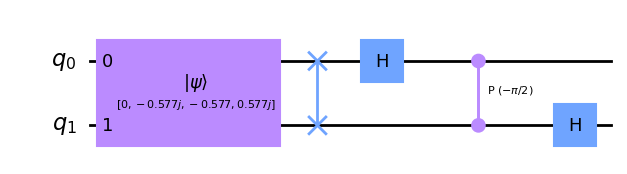

In [153]:
element_wise_qc = QuantumCircuit(2)
element_wise_qc.initialize(element_wise_state_norm)
iqft_circuit=QFT(num_qubits=2, inverse=True).decompose()
element_wise_qc_iqft = element_wise_qc.compose(iqft_circuit)
element_wise_qc_iqft.draw('mpl')

In [158]:
element_wise_qc_iqft_state = Statevector(element_wise_qc_iqft)
element_wise_qc_iqft_state

Statevector([-0.28867513-3.67503113e-18j, -0.28867513-3.53525080e-17j,
             -0.28867513+3.67503113e-18j,  0.8660254 +3.53525080e-17j],
            dims=(2, 2))


In [165]:
iqft_elementwise_state = Statevector(element_wise_qc_iqft)
iqft_elementwise_state = iqft_elementwise_state / np.sqrt(5)
print("Frequency domain multiplication = ","\n",iqft_elementwise_state.data)

Frequency domain multiplication =  
 [-0.12909944-1.64352388e-18j -0.12909944-1.58101222e-17j
 -0.12909944+1.64352388e-18j  0.38729833+1.58101222e-17j]


In [155]:
circular_convolution(initial_psi_state, initial_phi_state)

array([-0.12909944, -0.12909944, -0.12909944,  0.38729833])

# Color space QFT

In [2]:
n = 200
k = 100

start = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=200000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()
counts

C:\Users\HCI\AppData\Local\Temp\ipykernel_8340\2336452204.py:30: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


{'10': 90999, '00': 98270, '11': 8966, '01': 1765}

C:\Users\HCI\AppData\Local\Temp\ipykernel_8340\1224835838.py:30: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


0.40108 s
[array([201.36527588, 100.92918952,   0.        ])]


C:\Users\HCI\AppData\Local\Temp\ipykernel_8340\1224835838.py:102: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1,1,c=colors, marker='o')


Text(0, 0.5, 'Green')

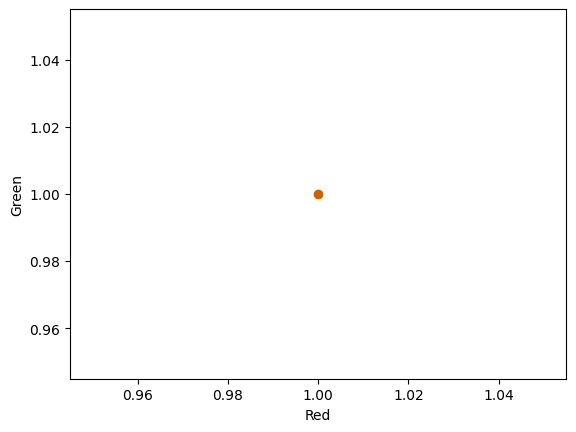

In [75]:
n = 200
k = 100

start = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=200000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color = []
for i in range(len(pixel_color_phi_recon)):
    n_recon = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon = pixel_color_phi_recon[i] * 6 * n_recon / np.pi
    recon_color.append(np.array([n_recon,k_recon,0]))
end = time.time()
time_simul = end - start
print(f'{time_simul:.5f}', "s")
print(recon_color)
recon_color_index = recon_color[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors = recon_color_index / 255
ax.scatter(1,1,c=colors, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

In [76]:
error = []
for i in range(1):
    del_x = recon_color[0][0] - n
    del_y = recon_color[0][1] - k
    err = del_x**2+del_y**2
    error.append(err)

print("error = ",error,"time = ", time_simul)

error =  [2.727371395714162] time =  0.40108275413513184


In [59]:
from qiskit_ionq import IonQProvider
provider = IonQProvider("api")

364.76714634895325 s
[array([206.00513058, 120.23284475,   0.        ])]


C:\Users\HCI\AppData\Local\Temp\ipykernel_8340\1410872363.py:100: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1,1,c=colors_ionq, marker='o')


Text(0, 0.5, 'Green')

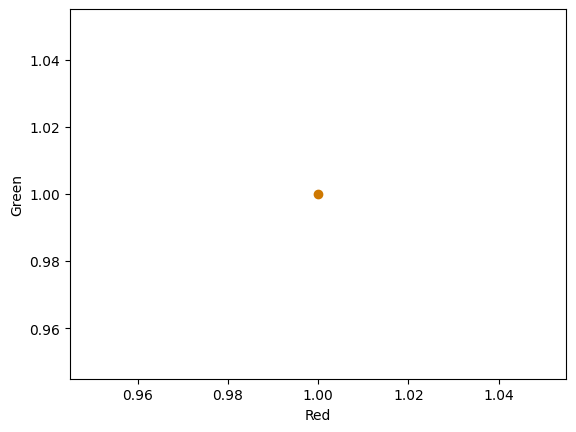

In [80]:
n = 200
k = 100

start = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=200000, noise_model="aria-1")
result_ionq = job_ionq.result()
counts_ionq = result_ionq.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n = pixel_color_theta_recon[i] * 1020 / np.pi
    k = pixel_color_phi_recon[i] * 6 * n / np.pi
    recon_color_ionq.append(np.array([n,k,0]))
end = time.time()
print(f'{end - start}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

In [ ]:
error_ionq = []
for i in range(1):
    del_x = recon_color_ionq[0][0] - n
    del_y = recon_color_ionq[0][1] - k
    err_ionq = np.sqrt(del_x**2+del_y**2)
    error_ionq.append(err)

print("error = ",error_ionq,"time = ", time_simul)

error =  [1.651475520773518] time =  0.40108275413513184


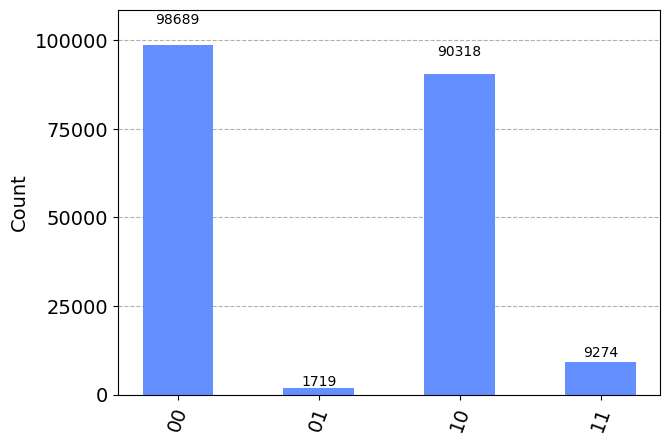

In [ ]:
plot_histogram(counts_ionq)

In [ ]:
qc.draw('mpl')

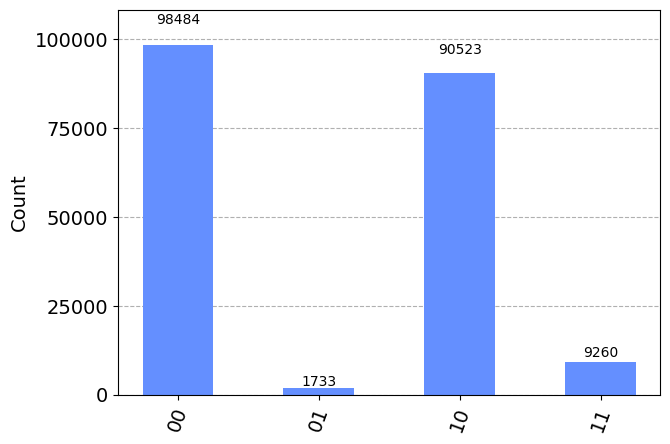

In [26]:
plot_histogram(counts)

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


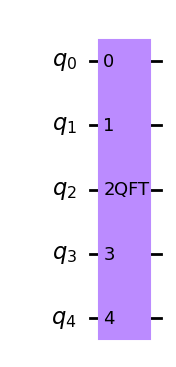

In [3]:
from qiskit.circuit.library import QFT

qft = QFT(5)
qft.draw('mpl')